# Disentanglement analysis of colored-bar-MNIST

Here, we will load the embedded colored-bar-MNIST dataset, which when fed through the VAE produces a 32-dimensional embedding.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from gendis.causal.modelv3 import CausalFlowModel, CausalNormalizingFlow
from gendis.datasets import MultiDistrDataModule

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.

In [152]:
def show_imgs(imgs, title=None, row_size=4, ytick_labels=None):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    ncol = min(num_imgs, row_size)
    nrow = int(math.ceil(num_imgs / ncol))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=row_size, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    fig, ax = plt.subplots(figsize=(1.5 * nrow * 2, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    if title is not None:
        plt.title(title)
    # plt.axis("off")
    plt.axis("on")
    ax.set_xticks([])

    # if ytick_labels is not None:
    #     # Number of images per row
    #     img_per_row = num_imgs // nrow + (num_imgs % nrow > 0)
    #     # Set yticks at the center of each row of images
    #     yticks = [i * np_imgs.shape[1] / img_per_row + np_imgs.shape[1] / (2 * img_per_row) for i in range(img_per_row)]
    #     ax.set_yticks(yticks)
    #     ax.set_yticklabels(ytick_labels[:img_per_row])
    if ytick_labels is not None:
        # print(nrow)
        ax.set_yticks([(i + 0.5) * imgs.shape[1] / nrow for i in range(nrow)])
        ax.set_yticklabels(ytick_labels[:nrow])
    # ax.set_yticks([(i + 0.5) * images.shape[1] / nrow for i in range(nrow)])
    # plt.close()
    return fig, ax

In [4]:
root = "/Users/adam2392/pytorch_data/"
root = Path(root)
new_root = root / "causalbar_reduction_dat/"
batch_size = 16
num_workers = 1

data_module = MultiDistrDataModule(
    root=new_root,
    graph_type="chain",
    batch_size=batch_size,
    stratify_distrs=True,
    transform=None,
    num_workers=num_workers,
)
data_module.setup()

In [36]:
root = Path("/Users/adam2392/pytorch_data/data/causal/")
graph_type = "chain"

# No independent noise factor
seed = 1
epoch = 67
step = 76500
results_dir = root / f"mlp-nf-onvae-reduction-cosinelr-batch32-{graph_type}-seed={seed}"

checkpoint_fname = results_dir / f"epoch={epoch}-step={step}.ckpt"
model = CausalFlowModel.load_from_checkpoint(checkpoint_fname)

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [34]:
imgs = []
labels = []
targets = []

for idx in data_module.train_dataset.indices:
    img, label, target = data_module.dataset[idx]
    imgs.append(img)
    labels.append(label)
    targets.append(target)

imgs = torch.vstack(imgs)
labels = torch.vstack(labels)
targets = torch.vstack(targets)
print(imgs.shape, labels.shape, targets.shape)

torch.Size([36000, 32]) torch.Size([36000, 5]) torch.Size([36000, 3])


In [37]:
# now forward these through the model
embeddings = model.model.inverse(imgs)
print(embeddings.shape)

torch.Size([36000, 32])


In [107]:
# now create a y for each latent factor
latent_targets = {
    "width": 0,
    "color-bar": 1,
    "color-digit": 2,
}

# XXX: in the latent embedding, order got messed up
latent_embeddings = {
    "width": np.arange(0, 11, dtype=int),
    "color-bar": np.arange(11, 22, dtype=int),
    "color-digit": np.arange(22, 32, dtype=int),
    # "color-digit": np.arange(11, 22, dtype=int),
    # "color-bar": np.arange(22, 32, dtype=int),
}

latent_names = ["width", "color-bar", "color-digit"]
n_repeats = 10

# (n_repeats, Vhat, V)
corr_arr = np.zeros((n_repeats, len(latent_names), len(latent_names)))

for rdx, random_state in enumerate(
    np.random.SeedSequence(1234).generate_state(n_repeats)
):
    cv = ShuffleSplit(n_splits=1, random_state=random_state)

    for i, name_src in enumerate(latent_names):
        jdx = latent_embeddings[name_src]
        X = embeddings[:, jdx].detach().numpy()

        for j, name_target in enumerate(latent_names):
            idx = latent_targets[name_target]
            y = labels[:, idx].detach().numpy()
            # reg = LinearRegression(fit_intercept=True)
            reg = RandomForestRegressor(max_features=0.3, random_state=random_state)
            r2s = cross_val_score(reg, X, y=y, cv=cv, scoring="r2")
            corr_coefficients = np.mean(
                np.sqrt(r2s)
            )  # To be comparable to MCC (this is the average of R = coefficient of multiple correlation)
            # print(X.shape, y.shape, r2s.shape, corr_coefficients.shape)
            corr_arr[rdx, i, j] = corr_coefficients

In [39]:
print(r2s)

[0.48131216]


Text(0.5, 16.944444444444436, '$V_i$')

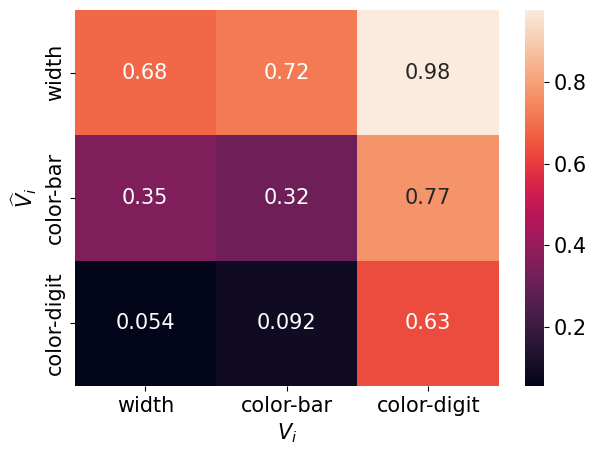

In [40]:
min_corr = corr_arr.min()
corr_arr = corr_arr - min_corr
max_corr = corr_arr.max()
corr_arr = corr_arr / max_corr

fig, ax = plt.subplots()
sns.heatmap(
    corr_arr.mean(axis=0),
    annot=True,
    xticklabels=latent_names,
    yticklabels=latent_names,
    ax=ax,
)
ax.set_ylabel("$\widehat{V}_i$")
ax.set_xlabel("$V_i$")

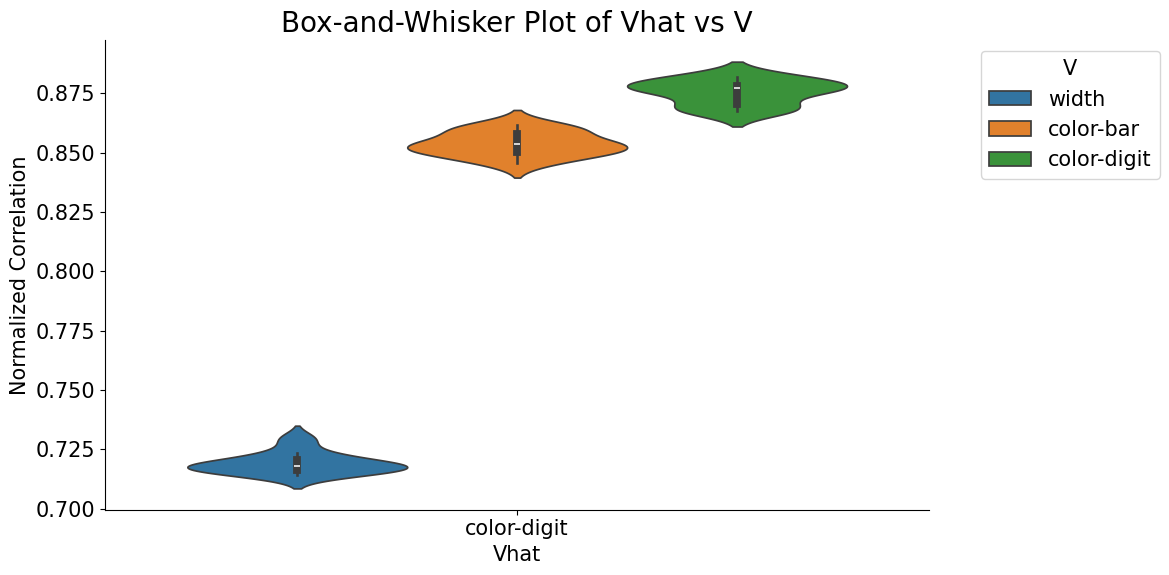

In [109]:
# Reshape corr_arr to long format
data = []
for rdx in range(n_repeats):
    for i, name_src in enumerate(latent_names):
        for j, name_target in enumerate(latent_names):
            data.append([rdx, name_src, name_target, corr_arr[rdx, i, j]])

# Create a DataFrame
df = pd.DataFrame(data, columns=["repeat", "Vhat", "V", "correlation"])
df = df[df["Vhat"] == "color-digit"]

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.violinplot(x="Vhat", y="correlation", hue="V", data=df)
plt.title("Box-and-Whisker Plot of Vhat vs V")
plt.xlabel("Vhat")
plt.ylabel("Normalized Correlation")
plt.legend(title="V", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Pick random images to compare their embeddings

In [65]:
import sys

sys.path.append("../")
sys.path.append("../vae_reduction/")
from config.config import load_config
from models import vae_models


def make_model(config):
    model_type = config.model_type
    model_config = config.model_configuration

    if model_type not in vae_models.keys():
        raise NotImplementedError("Model Architecture not implemented")
    else:
        return vae_models[model_type](**model_config.dict())


def load_vae_model(config, data_root, model_root):
    config.model_configuration.data_path = data_root
    model = make_model(config)
    checkpoint = torch.load(model_root, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["state_dict"])
    return model


config = load_config("../config.yaml")

train_iter = iter(data_module.train_dataloader())

In [63]:
data_root = Path("/Users/adam2392/pytorch_data/")
model_root = data_root / "vae-reduction" / "conv-vae_alpha_1024_dim_32.ckpt"

# load the VAE and extra the corresponding image
# load vae model
vae_model = load_vae_model(config, data_root, model_root)
vae_model.eval()

Conv_VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [99]:
# randomly sample
batch = next(train_iter)
sample_imgs, sample_labels, sample_target = batch

print(sample_imgs.shape, sample_labels.shape, sample_target.shape)

torch.Size([16, 32]) torch.Size([16, 5]) torch.Size([16, 3])


In [100]:
print(sample_target)

tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1]], dtype=torch.int32)


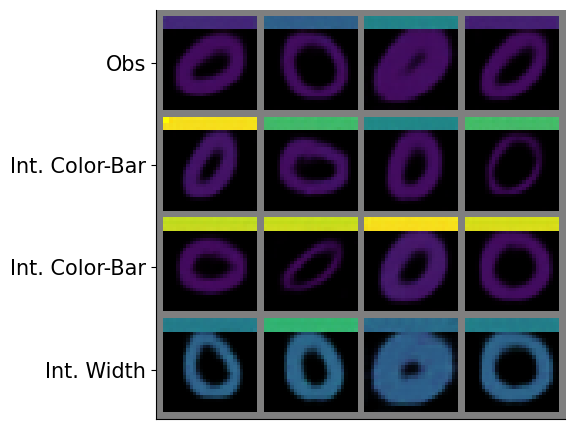

In [101]:
# Initialize an empty list to hold the sorted rows
sorted_rows = []
distribution_indices = sample_labels[:, -1]
# Loop through the unique distribution indices
for i in range(4):  # Assuming unique distribution indices are 0, 1, 2, and 3
    # Get the indices where the distribution index equals i
    indices = (distribution_indices == i).nonzero(as_tuple=True)[0]
    # Append the corresponding rows to the sorted_rows list
    sorted_rows.append(sample_imgs[indices])

# Concatenate the sorted rows into a single tensor
sorted_imgs = torch.cat(sorted_rows, dim=0)

with torch.no_grad():
    images = vae_model.decoder(sorted_imgs)
images = vae_model.scale_image(images)

fig, ax = show_imgs(
    images, ytick_labels=["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Width"]
)
# ax.set_yticklabels(["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Width"])
# ax.set_yticks([(i + 0.5) * images.shape[1] / nrow for i in range(nrow)])
# ax.set_yticklabels()

# Intervene on Causal Prior to change the embeddings

In [139]:
# get observational images and their priors in the NF
obs_idx = np.argwhere(sample_labels[:, -1] == 0)[0]
obs_imgs = sample_imgs[obs_idx, ...]

# now forward these through the model
obs_embeddings = model.model.inverse(obs_imgs)

# intervene on the embedding in the relevant space
v_idx = latent_embeddings["color-digit"]
obs_embeddings[:, v_idx] += 2.0 * torch.randn(obs_embeddings[:, v_idx].shape)
print(embeddings.shape)
print(obs_imgs.shape)

intervened_imgs = model.model.forward(obs_embeddings)
# fig, ax = show_imgs(
# images, ytick_labels=["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Width"]

torch.Size([36000, 32])
torch.Size([4, 32])


In [140]:
print(intervened_imgs.shape)
with torch.no_grad():
    observed_imgs = vae_model.decoder(obs_imgs)
observed_imgs = vae_model.scale_image(observed_imgs)
with torch.no_grad():
    intervened_imgs = vae_model.decoder(intervened_imgs)
intervened_imgs = vae_model.scale_image(intervened_imgs)
print(intervened_imgs.shape)
print(obs_imgs.shape)

torch.Size([4, 32])
torch.Size([4, 3, 28, 28])
torch.Size([4, 32])


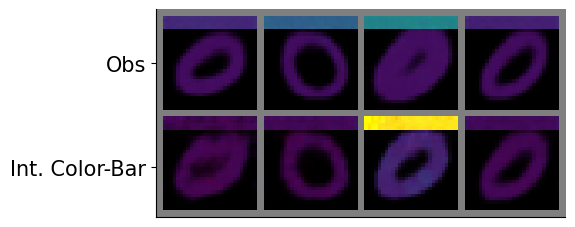

In [153]:
images = torch.vstack((observed_imgs, intervened_imgs))
fig, ax = show_imgs(images, row_size=4, ytick_labels=["Obs", "Int. Color-Bar"])